# Drive

In [ ]:
# mount personal drive folder
# could be ignored for simplicity
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# if mount, choose a path in your google Drive
# this path contains or will contain all the files used
# including, dataset, model weights, etc
# you can also set these paths seperatelly at where they are used
path='/content/drive/MyDrive/codingres/'

In [ ]:
# if not mount, choose a path in the Colab ephemeral environment
path='/'

# Dataset (class)

Dataset class and visulization function

In [ ]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

In [ ]:
class ContDataset(Dataset):
  """Prepare dataset for contrastive learning

  Args:
    folder_path (string): Path to the folder with images.
    transform (callable, optional): Optional transform to be applied
        on a sample.
  """

  def __init__(self, folder_path, folder_path1, transform=None):
    self.folder_path = folder_path
    self.folder_path1 = folder_path1
    self.image_filenames = [f for f in sorted(os.listdir(folder_path)) if os.path.isfile(os.path.join(folder_path, f))]
    self.image_filenames1 = [f for f in sorted(os.listdir(folder_path1)) if os.path.isfile(os.path.join(folder_path1, f))]
    self.transform = transform

  def __len__(self):
    # Return the total number of image pairs
    # There is one less pair than the number of images
    return len(self.image_filenames1) - 1

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name_0 = os.path.join(self.folder_path1, self.image_filenames1[idx])
    img_name_1 = os.path.join(self.folder_path, self.image_filenames[idx])
    img_name_2 = os.path.join(self.folder_path, self.image_filenames[idx + 1])

    image_0 = Image.open(img_name_0)
    image_1 = Image.open(img_name_1)
    image_2 = Image.open(img_name_2)

    if self.transform:
        image_0 = self.transform(image_0)
        image_1 = self.transform(image_1)
        image_2 = self.transform(image_2)

    # No label is provided, just the pair of images
    return image_0, image_1, image_2


In [ ]:
class MockContDataset(Dataset):
  """prepare random dataset for contrastive learning

  Args:
    num_samples (int): Number of samples in the dataset.
    image_size (tuple): Size of the generated images (height, width).
    transform (callable, optional): Optional transform to be applied
        on a sample.
  """

  def __init__(self, num_samples:int, image_size=(224, 224), transform=None):
    self.num_samples = num_samples
    self.image_size = image_size
    self.transform = transform

  def __len__(self):
    # Return the total number of image pairs
    # There is one less pair than the number of images
    return self.num_samples - 1

  def __getitem__(self, idx):
    # Generate random images
    image_0 = Image.fromarray(np.random.randint(0, 255, (self.image_size[0], self.image_size[1], 3), dtype=np.uint8))
    image_1 = Image.fromarray(np.random.randint(0, 255, (self.image_size[0], self.image_size[1], 3), dtype=np.uint8))
    image_2 = Image.fromarray(np.random.randint(0, 255, (self.image_size[0], self.image_size[1], 3), dtype=np.uint8))

    if self.transform:
        image_0 = self.transform(image_0)
        image_1 = self.transform(image_1)
        image_2 = self.transform(image_2)

    # No label is provided, just the pair of images
    return image_0, image_1, image_2

In [ ]:
class Transform:
  """transform the images and correspounding pixel-wise lables to a pre-defined shape"""

  def __init__(self, image_size=(224, 224)):
    self.image_size = image_size
    self.transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])

  def __call__(self, img, mask):
    img = self.transform(img)
    # Assuming mask is a PIL image, resize it as the img and convert to tensor.
    mask = F.resize(mask, self.image_size, Image.NEAREST)
    mask = torch.tensor(np.array(mask), dtype=torch.long)  # Masks don't need normalization but need to be torch tensors
    return img, mask


In [ ]:
def check_image_shapes(folder_path):
  """check the modes of data

  Args:
    folder_path: path of the folder

  Returns:
    modes: dict with mode as keys and number of files as values
    filennames: filenmames with the images whose modes are nor RGB
  """

  modes = {}
  filenames = []
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
      image_path = os.path.join(folder_path, filename)
      with Image.open(image_path) as img:
        # Get image dimensions and channels (mode)
        width, height = img.size
        mode = img.mode
        if mode not in modes:
          modes[mode] = 1
        else:
          modes[mode] += 1

        if mode != 'RGB':
          filenames.append(filename)
  return modes, filenames

In [ ]:
def seg_visualize(data:tuple, color_background=[255,255,255], color_edge=[255,0,0], transparency=0.75):
  '''Visualize the image with the egde

  Args:
      data: (image,trimap) where images is (channels, width, height) and trimap is (width, height)
      color_background: RGB vales to cover the backgroung, i.e. trimap == 2
      color_edge: RGB vales to show the edge with transparency, i.e. trimap == 3
      transparency: the transparency factor for the edge
  '''

  image = data[0].numpy()
  trimap = data[1].numpy()

  # convert to image with (width,height,channels) as shape and unit8 0~255 as values
  image = (image * 255).astype(np.uint8)
  image = image.transpose((1, 2, 0))

  image_original = image.copy()

  # show background
  image[trimap == 2] = color_background

  # show edge
  blend = np.array(color_edge, dtype=np.uint8)
  mask = trimap == 3
  image[mask] = (transparency * image[mask] + (1 - transparency) * blend).astype(np.uint8)

  %matplotlib inline
  # show the original image and the segmentated one
  plt.subplot(1, 2, 1)
  plt.imshow(image_original)
  plt.axis('off')
  plt.title('Original Image')

  plt.subplot(1, 2, 2)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Segmentated Image')

  plt.show()

# Models

models class

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16
from torchvision.transforms import functional as F

In [ ]:
class BaseModel(nn.Module):
  """base model


  Args:
      pretrained (bool): true indicates loading pre-trained weights

  Attributes:
    vit: vistion transformer without classification head
  """

  def __init__(self, pretrained = True):
    super().__init__()
    self.vit = vit_b_16(pretrained=pretrained)
    self.vit.heads = nn.Identity()

  def forward(self,x):
    outputs = self.vit(x)

    return outputs


In [ ]:

class SelfSuperviseHead(nn.Module):
  """convert to the original image shape

  Args:
    dim (int): imput dimension
    image_size (tuple[int]): (width,height) of input image
  """

  def __init__(self,dim=768,image_size=(224,224)):
    super().__init__()
    self.image_size = image_size
    self.projection = nn.Linear(dim, 3 * image_size[0] * image_size[1])

  def forward(self,x):
    batch_size = x.size(0)
    outputs = self.projection(x)
    outputs = outputs.reshape(batch_size, 3, self.image_size[0], self.image_size[1])

    return outputs


class SegmentationHead(nn.Module):
  """segmentation head

  Args:
    num_class (int): number of classes
    dim (int): imput dimension
    image_size (tuple[int]): (width,height) of input image
    c1, c2, c3 (int): channels in upsampling, c1(input) -> c2 -> c3 -> num_classes(output)

  """

  def __init__(self,num_classes=3,dim=768,image_size=(224,224),c1=64,c2=32,c3=16):
    super().__init__()
    self.image_size = image_size
    self.c1 = c1
    self.projection = nn.Linear(dim, c1 * image_size[0] * image_size[1])

    # Decoder to upsample the patch representations to the original image resolution
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(c1, c2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(c2, c3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(c3, num_classes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

  def forward(self,x):
    batch_size = x.size(0)
    outputs = self.projection(x)
    outputs = outputs.reshape(batch_size, self.c1, self.image_size[0], self.image_size[1])
    outputs = self.decoder(outputs)

    return outputs


In [ ]:
class BaseSelfSupervise(nn.Module):
  """Base model with selfsupervied head, i.e. projection for selfsupervie learning

  Args:
    word_dim (int): word vector dimension in ViT
    image_size (tuple[int]): (width, height) of imput images
    base_model_weights (None|'pretrained'|str|dict), can be:
      'pretrained': load the pretrained vit weights automatically
      base model path (str): load the weights from model path
      base model class (BaseModel): integrate the base model
      base model weights (dict): load the weight from this dict
      None: do not load pre-trained weights
  """
  def __init__(self, word_dim=768, image_size=(224,224), base_model_weights=None):
    super().__init__()

    #save attribute
    if type(base_model_weights) is BaseModel:
      self.base_model = base_model_weights
    elif base_model_weights=='pretrain':
      self.base_model = BaseModel(True)
    else:
      self.base_model = BaseModel(False)
      if type(base_model_weights) == dict:
        self.base_model.load_state_dict(base_model_weights)
      elif type(base_model_weights) == str:
        self.base_model.load_state_dict(torch.load(base_model_weights))
      elif base_model_weights is not None:
        raise ValueError('unknown base_model_weights')

    self.heads = SelfSuperviseHead()


  def forward(self, x):

      outputs = self.base_model(x)
      outputs = self.heads(outputs)

      return outputs


class BaseSegmentation(nn.Module):
  """Base model with segmentation head for segmentation task

  Args:
    num_classes: number of classes
    word_dimm: word vector dimension in ViT
    image_size: (width, height) of imput images
    c1, c2, c3: channels in upsampling, c1(input) -> c2 -> c3 -> num_classes(output)
    base_model_weights (None|'pretrained'|str|dict), can be:
      'pretrained': load the pretrained vit weights automatically
      base model path (str): load the weights from model path
      base model class (BaseModel): integrate the base model
      base model weights (dict): load the weight from this dict
      None: do not load pre-trained weights
  """

  def __init__(self, num_classes=3, word_dim=768, image_size=(224,224), c1=64,c2=32,c3=16, base_model_weights=None):
    super().__init__()

    #save attribute
    if type(base_model_weights) is BaseModel:
      self.base_model = base_model_weights
    elif base_model_weights=='pretrain':
      self.base_model = BaseModel(True)
    else:
      self.base_model = BaseModel(False)
      if type(base_model_weights) == dict:
        self.base_model.load_state_dict(base_model_weights)
      elif type(base_model_weights) == str:
        self.base_model.load_state_dict(torch.load(base_model_weights))
      elif base_model_weights is not None:
        raise ValueError('unknown base_model_weights')

    self.heads = SegmentationHead(num_classes,word_dim,image_size,c1,c2,c3)


  def forward(self, x):

      outputs = self.base_model(x)
      outputs = self.heads(outputs)

      return outputs


In [ ]:
class ViTSegmentation(nn.Module):
  """ViT with decoder for segmentation task

  Args:
    num_classes: number of classes
    word_dimm: word vector dimension in ViT
    image_size: (width, height) of imput images
    c1, c2, c3: channels in upsampling, c1(input) -> c2 -> c3 -> num_classes(output)
    pretrained: bool, true indicates pre-trained weights for vit_b_16
  """

  def __init__(self, num_classes=3, word_dim=768, image_size=(224,224), c1=64,c2=32,c3=16, pretrained=True):
    super().__init__()

    #save attribute
    self.image_size = image_size
    self.c1 = c1

    # Load a pretrained ViT model
    self.vit = vit_b_16(pretrained=pretrained)
    self.vit.heads = nn.Identity()  # Remove the classification head
    self.projection = nn.Linear(word_dim, c1 * image_size[0] * image_size[1])

    # Decoder to upsample the patch representations to the original image resolution
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(c1, c2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(c2, c3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(c3, num_classes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

  def forward(self, x):
    # ViT outputs one feature vector per patch, plus a class token
    # Here, we reshape the patch features to a feature map and pass it through the decoder
    batch_size = x.size(0)

    vit_features = self.vit(x)
    x = self.projection(vit_features)

    x = x.reshape(batch_size, self.c1, self.image_size[0], self.image_size[1])
    out = self.decoder(x)

    return out

In [ ]:
## mae

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.decoder(x)


class MaskedAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(MaskedAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, mask):
        x_masked = mask * x
        encode_patch = self.encoder(x_masked)
        reconstruct = self.decoder(encode_patch)

        return reconstruct

# Loss

loss and accuracy functions

In [ ]:
import torch.nn.functional as Func

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Calculate the positive pair distance
        pos_dist = Func.pairwise_distance(anchor, positive)
        # Calculate the negative pair distance
        neg_dist = Func.pairwise_distance(anchor, negative)

        # Calculate the contrastive loss
        loss = torch.mean((pos_dist ** 2) + torch.clamp(self.margin - neg_dist, min=0.0) ** 2)

        return loss

contrastive_loss = ContrastiveLoss(margin=1.0)

In [ ]:
def dice_loss(pred:torch.Tensor, target:torch.Tensor, smooth=1.0):
    '''calculate dice loss

    Args:
        pred: output of model, (batch_size, num_class, width, height)
        target: true prediction for eac pixel, (batch_size, width, height)
        smooth: smooth parameter for dice loss

    Return:
        dice_loss: dice loss
    '''

    _, num_classes, _, _ = pred.shape
    target = target -1 # convert values from 1-3 to 0-2

    assert target.min() >= 0 and target.max() < num_classes, 'target contains invalid class indices'

    pred = torch.nn.functional.softmax(pred, dim=1)  # Convert logits to probabilities

    # convert targets, trimap, to one shot
    # (batch_size, width, height) -> (batch_size, 3, width, height)
    targets_one_hot = torch.nn.functional.one_hot(target, num_classes).permute(0, 3, 1, 2)
    targets_one_hot = targets_one_hot.type_as(pred)

    # calculate dice_score for each (batch,class)
    intersection = torch.sum(pred * targets_one_hot, dim=(2, 3))  # sum over width and height
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    dice_score = (2. * intersection + smooth) / (union + smooth)

    dice_loss = 1. - dice_score.mean() # aveerage over batch and num_classes

    return dice_loss

In [ ]:
def pixel_wise_accuracy(pred:torch.Tensor,target:torch.Tensor) -> float :
    '''calculate pixe-wise accuracy

    Args:
        pred: output (logits) of model, (batch_size, num_classes, width,height)
        target: ground truth, trimap
    Returns:
        accuracy: pixel accuracy
    '''

    pred_tri = torch.argmax(pred,axis=1)
    target = target - 1

    accuracy = torch.sum(pred_tri == target) / pred_tri.numel()

    return accuracy.item()


### test loss

In [ ]:
## test dice loss
targets = torch.tensor([
    [[1,1],[2,2]],
    [[1,1],[2,2]]
])

preds = torch.tensor([
    [
        [[10,10],[0,0]],
        [[0,0],[10,10]]
    ],
    [
        [[10,10],[0,0]],
        [[0,0],[10,10]]
    ]
]).type(torch.float32)

## should be close to 0
print(np.round(dice_loss(preds,targets).numpy(),3))

0.0


In [ ]:
## test dice loss
targets = torch.tensor([
    [[1,1],[2,2]],
    [[1,1],[2,2]]
])

preds = torch.tensor([
    [
        [[10,10],[0,0]],
        [[0,0],[10,10]]
    ],
    [
        [[10,10],[0,0]],
        [[0,0],[10,10]]
    ]
]).type(torch.float32)

## should be close to 1
print(np.round(pixel_wise_accuracy(preds,targets),3))

1.0


In [ ]:
## test contrastive loss
anchor = torch.randn((4,10))
positive = anchor
negative = anchor - 10
# should be close to 0
print(contrastive_loss(anchor,positive,negative))

anchor = torch.randn((4,4,10))
positive = anchor
negative = anchor - 10

# should be close to 0
print(contrastive_loss(anchor,positive,negative))

tensor(1.0000e-11)
tensor(1.0000e-11)


# Pre-Train

different pre-training processes. Base Model + SelfSupervise Head is selected now

In [ ]:
%%capture
!unzip {path+'data.zip'}

In [ ]:
%%capture
!unzip {path+'aug_data.zip'}

In [ ]:
!unzip "/content/drive/MyDrive/Copy of data.zip"

In [ ]:
!unzip "/content/drive/MyDrive/Copy of aug_data.zip"

In [ ]:
!ls -1 /content/data | wc -l

48068


In [ ]:
!ls -1 /content/aug_data | wc -l

96136


In [ ]:
## check
folder_path = '/content/data'
modes, filenames = check_image_shapes(folder_path)
print(modes)

{'RGB': 48062}


In [ ]:
folder_path = '/content/aug_data'
modes,_ = check_image_shapes(folder_path)
print(modes)

{'RGB': 96124}


In [ ]:
# Define a transform to convert the images to PyTorch tensors and any other desired transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
## load data

dataset = ContDataset(folder_path='/content/aug_data', folder_path1='/content/data', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [ ]:
## load random data
##

dataset = MockContDataset(num_samples = 120, transform = transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

## Base Model + SelfSupervise Head

pre-trained model and the finetuned model have same base model / backbone but different heads

In [ ]:
## pre-train model

model = BaseSelfSupervise(base_model_weights=None)
if torch.cuda.device_count() > 1:
  print(f"using {torch.cuda.device_count()} GPUs")
  model = nn.DataParallel(model)

model.to("cuda")


In [ ]:
## train self-supervised model

optimizer = optim.SGD(model.parameters(), lr=1e-3)

model = model.half()
model.train()
for epoch in range(1):
  for x, z1, z2 in dataloader:
    inputs, x1, x2 = x.to("cuda").half(), z1.to("cuda").half(), z2.to("cuda").half()
    optimizer.zero_grad()

    p1, p2 = model(x1), model(x2)
    loss = contrastive_loss(inputs, p1, p2)

    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}, Loss: {loss.item()}')

torch.save(model.state_dict(), path+'BaseSelfSupervise.pth')

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [4, 224, 224] at entry 2

## ViTSegmentation (pre-train)

same structure for both pre-trained model and fine-tuned model

In [ ]:
model = ViTSegmentation(num_classes=3).half()

# set parallel mode for multi GPUs
if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to("cuda")

In [ ]:
# optional
# freeze parameters of the pre-trained ViT
if torch.cuda.device_count() > 1:
    for param in model.module.vit.parameters():
        param.requires_grad = False
else:
    for param in model.vit.parameters():
        param.requires_grad = False

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# half precision

optimizer = optim.SGD(model.parameters(), lr=1e-3)
model = model.half()

# Training loop
for epoch in range(5):
    model.train()
    loss_min = 50
    for x, z1, z2 in dataloader:
        inputs, x1, x2 = x.to("cuda").half(), z1.to("cuda").half(), z2.to("cuda").half()
        # mask1, mask2 = torch.rand(size=(1,3,224,224))>.75, torch.rand(size=(1,3,224,224))>.75
        # mask1, mask2 = mask1.to(device), mask2.to(device)
        # x1, x2 = mask1 * inputs, mask2*inputs

        optimizer.zero_grad()

        p1, p2 = model(x1), model(x2)
        loss = contrastive_loss(inputs, p1, p2)
        # accuracy = pixel_wise_accuracy(preds, targets)

        # test
        # if loss.item()<loss_min:
        #   loss_min = loss.item()
        #   print('loss : {:.3f}'.format(loss_min))

        loss.backward()

        optimizer.step()

    # print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

loss : 18.875
loss : 18.844
loss : 18.812
Epoch 1, Loss: 18.84375
loss : 18.875
loss : 18.828
loss : 18.812
loss : 18.781
Epoch 2, Loss: 18.8125
loss : 18.828
loss : 18.797
loss : 18.781
Epoch 3, Loss: 18.796875
loss : 18.828
loss : 18.812
loss : 18.781
Epoch 4, Loss: 18.828125
loss : 18.812
loss : 18.797
loss : 18.781
Epoch 5, Loss: 18.8125


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

ml = 1000
# Training loop
for epoch in range(10):
    model.train()
    for x, z1, z2 in dataloader:
        inputs, x1, x2 = x.to("cuda").half(), z1.to("cuda").half(), z2.to("cuda").half()
        # mask1, mask2 = torch.rand(size=(1,3,224,224))>.75, torch.rand(size=(1,3,224,224))>.75
        # mask1, mask2 = mask1.to(device), mask2.to(device)
        # x1, x2 = mask1 * inputs, mask2*inputs
        #model = model.half()
        optimizer.zero_grad()

        p1, p2 = model(x1), model(x2)
        loss = contrastive_loss(inputs, p1, p2)
        # accuracy = pixel_wise_accuracy(preds, targets)

        # test
        if loss.item()<ml:
          ml = loss.item()
          print('loss : {:.3f}'.format(loss.item()))

        loss.backward()

        optimizer.step()

    # print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

loss : 32.625
loss : 31.203
loss : 31.188
loss : 31.094
loss : 30.859


KeyboardInterrupt: 

half data

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

ml = 50
# Training loop
for epoch in range(1):
    model.train()
    for (idx, (x, z1, z2)) in enumerate(dataloader):
        if (idx+1)%2==0: continue
        inputs, x1, x2 = x.to("cuda").half(), z1.to("cuda").half(), z2.to("cuda").half()
        # mask1, mask2 = torch.rand(size=(1,3,224,224))>.75, torch.rand(size=(1,3,224,224))>.75
        # mask1, mask2 = mask1.to(device), mask2.to(device)
        # x1, x2 = mask1 * inputs, mask2*inputs
        #model = model.half()
        optimizer.zero_grad()

        p1, p2 = model(x1), model(x2)
        loss = contrastive_loss(inputs, p1, p2)
        # accuracy = pixel_wise_accuracy(preds, targets)

        # test
        if loss.item()<ml:
          ml = loss.item()
          print('loss : {:.3f}'.format(loss.item()))

        loss.backward()

        optimizer.step()

    # print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

loss : 32.625
loss : 31.203
loss : 31.094
loss : 30.859


KeyboardInterrupt: 

# Fine-Tune

different fine-tuning processes. Base Model + Segmentation Head is selected now

In [ ]:
# When initializing your OxfordIIITPet dataset, you can use:
transform = Transform()
full_dataset = torchvision.datasets.OxfordIIITPet(root=path,
                        target_types='segmentation',
                        transforms=transform,
                        download=True)


# Define the size of your training and testing datasets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([3, 224, 224])
torch.Size([224, 224])


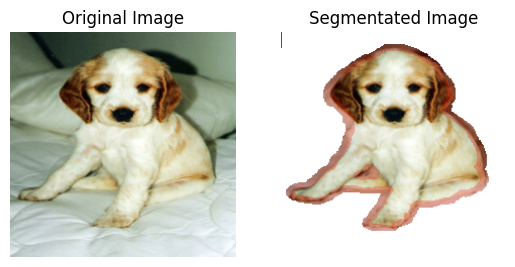

In [ ]:
seg_visualize(train_dataset[0])

## Base Model + Segmentation Head

pre-trained model and the finetuned model have same base model / backbone but different heads

In [ ]:
# must sent the pre-trained model tensor to CPU
# otherwise the GPU memory occupied by the model will not be released
# after torch.cuda.empty_cache()
model.to('cpu')

In [ ]:
model = BaseSegmentation(base_model_weights=model.base_model)
# model = BaseSegmentation(base_model_weights='pretrain')

# set parallel mode for multi GPUs
if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to("cuda")

In [ ]:
# release memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Training loop
model = model.half()
model.train()
for epoch in range(1):
  for x, y in train_loader:
    inputs, targets = x.to("cuda").half(), y.to("cuda")
    optimizer.zero_grad()

    preds = model(inputs)
    loss = dice_loss(preds, targets)
    accuracy = pixel_wise_accuracy(preds, targets)

    # test
    print(loss.item())

    loss.backward()

    optimizer.step()

  print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')
torch.save(model.state_dict(), path+'BaseSegmentation.pth')

## ViTSegmentation (fine-tune)

same structure for both pre-trained model and fine-tuned model


### half precision: fp16

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    model.train()
    for x, y in train_loader:
        inputs, targets = x.to("cuda").half(), y.to("cuda")
        model = model.half()
        optimizer.zero_grad()

        preds = model(inputs)
        loss = dice_loss(preds, targets)
        accuracy = pixel_wise_accuracy(preds, targets)

        # test
        #print('loss : {:.3f}, accuracy : {:.3f}'.format(loss.item(),accuracy))

        loss.backward()

        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')

### mixed precision: fp16+32

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(1):
    model.train()
    for x, y in train_loader:
        inputs, targets = x.to("cuda"), y.to("cuda")
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(inputs)
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)

        # test
        print('loss : {:.3f}, accuracy : {:.3f}'.format(loss.item(),accuracy))

        scaler.scale(loss).backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')

### test

In [ ]:
if torch.cuda.device_count() > 1:
    for param in model.module.base_model.parameters():
        param.requires_grad = False
else:
    for param in model.base_model.parameters():
        param.requires_grad = False

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
# Training loop
for epoch in range(2):
  model.train()
  for x, y in train_loader:
    inputs, targets = x.to("cuda").half(), y.to("cuda")
    model = model.half()
    optimizer.zero_grad()

    preds = model(inputs)
    loss = dice_loss(preds, targets)
    accuracy = pixel_wise_accuracy(preds, targets)

    print(loss.item())

    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')

## Masked-Autoencoder

Supervised Masked-Autoencoder model


In [ ]:
device = "cuda:0"

In [ ]:
encoder = vit_b_16(pretrained=True).to(device)
decoder = Decoder(1000, 512, 3*224*224).to(device)
mae_model = MaskedAutoEncoder(encoder, decoder).to(device)

# simple mask
mask = torch.rand(size=(1,3,224,224))>.75
mask = mask.to(device)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(mae_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    mae_model.train()
    for x, y in train_loader:
        inputs, targets = x.to("cuda"), y.to("cuda")
        #print(inputs.shape, targets.shape)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = mae_model(inputs, mask)
            preds = preds.reshape(4, 3, 224, 224)
            #print(targets.dtype)
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)

        # test
        #print('loss : {:.3f}, accuracy : {:.3f}'.format(loss.item(),accuracy))

        scaler.scale(loss).backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')



Epoch 1, Loss: 0.5714879035949707, Accuracy: 0.5376823544502258
Epoch 2, Loss: 0.5145551562309265, Accuracy: 0.5769142508506775
Epoch 3, Loss: 0.4972738027572632, Accuracy: 0.6139090061187744
Epoch 4, Loss: 0.534565806388855, Accuracy: 0.5752251744270325
Epoch 5, Loss: 0.5270661115646362, Accuracy: 0.5629534125328064
Epoch 6, Loss: 0.49492108821868896, Accuracy: 0.6046964526176453
Epoch 7, Loss: 0.561659574508667, Accuracy: 0.5351113677024841
Epoch 8, Loss: 0.49849915504455566, Accuracy: 0.6134157776832581
Epoch 9, Loss: 0.537715494632721, Accuracy: 0.5837053656578064
Epoch 10, Loss: 0.5308352112770081, Accuracy: 0.5691864490509033


In [ ]:
model = mae_model

optimizer = optim.SGD(model.parameters(), lr=1e-3)

loss_min = 50
# Training loop
for epoch in range(1):
    model.train()
    for x, z1, z2 in dataloader:
        inputs, x1, x2 = x.to("cuda").half(), z1.to("cuda").half(), z2.to("cuda").half()
        # mask1, mask2 = torch.rand(size=(1,3,224,224))>.75, torch.rand(size=(1,3,224,224))>.75
        # mask1, mask2 = mask1.to(device), mask2.to(device)
        # x1, x2 = mask1 * inputs, mask2*inputs
        model = model.half()
        optimizer.zero_grad()

        p1, p2 = model(x1, mask).reshape(3,224,224), model(x2, mask).reshape(3,224,224)
        loss = contrastive_loss(inputs, p1, p2)
        #accuracy = pixel_wise_accuracy(preds, targets)

        # test
        if loss.item()<loss_min:
          loss_min = loss.item()
          print('loss : {:.3f}'.format(loss_min))

        loss.backward()

        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

loss : 49.781
loss : 40.406
loss : 26.328
loss : 18.469
loss : 12.609
loss : 7.039
loss : 4.586


NameError: name 'accuracy' is not defined

In [ ]:
print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 59.5625
